# Clinical Notes Analysis – NER & Disease Classification
**Author:** Maria Kalimeri  
**Domain:** Application of NLP in Healthcare  
**Date:** October 2025

---

## 1. Introduction
In this project, I will use a dataset containing clinical notes to examine how Natural Language Processing techniques cam be applied to extract diseases, medications, and symptoms, as well as classify patient records into disease categories.  

**Goals:**
- Named Entity Recognition (NER)
- Entity linking with UMLS or SNOMED CT
- Disease classification
- Visualisation of insights

---

First, we need to import the necessary libraries. The installation of the libraries has been performed in a dedicated conda environment (see README.md). **If the environment has not been created yet, do this before continuing!**

In [1]:
# Imports

from pathlib import Path
import sys
import textwrap
from wordcloud import WordCloud

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scispacy
import seaborn as sns
import spacy
from spacy import displacy
from spacy.cli import download

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Install and import scispacy models
print('Geting scispacy models')
! python -m pip install "en_ner_bc5cdr_md @ https://huggingface.co/daviibrt/en_ner_bc5cdr_md/resolve/main/en_ner_bc5cdr_md-any-py3-none-any.whl" -q
import en_ner_bc5cdr_md


/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Geting scispacy models
DEPRECATION: Wheel filename 'en_ner_bc5cdr_md-any-py3-none-any.whl' is not correctly normalised. Future versions of pip will raise the following error:
Invalid wheel filename (invalid version): 'en_ner_bc5cdr_md-any-py3-none-any'

 pip 25.3 will enforce this behaviour change. A possible replacement is to rename the wheel to use a correctly normalised name (this may require updating the version in the project metadata). Discussion can be found at https://github.com/pypa/pip/issues/12938


Make sure the correct versions of Python/spacy/scispacy are being used

In [2]:
# Versions installed
print("Python executable:", sys.executable)
print("spaCy version:", spacy.__version__)
print("SciSpaCy version:", scispacy.__version__)

# Validate spaCy instalation
! python -m spacy validate

Python executable: /Users/mariakalimeri/opt/anaconda3/envs/nlp_env/bin/python
spaCy version: 3.6.1
SciSpaCy version: 0.5.3
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.6.1) =================
ℹ spaCy installation:
/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/spacy

NAME                  SPACY            VERSION                            
en_ner_bc5cdr_md      >=3.6.1,<3.7.0   0.5.3   ✔
en_core_sci_scibert   >=3.6.1,<3.7.0   0.5.3   ✔



**Note regarding the scispacy model used**

As explained in the README file, in order to use scispacy, an older version of spacy, and other libraries, needed to be used. The scispacy libraries compatible with this version of spacy are not widely available. Specifically, I was able to only use library *en_ner_bc5cdr_md* succesfully. This library's pipeline contains the following components: tok2vec, tagger, attribute_ruler, lemmatizer, parser, ner

As a result, I was able to use this library for preprocessing of the text (tokenization, lemmatization) as well as for Named Entity Recognition (NER).

## 2. Dataset

I used the following dateset:  https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions?resource=download  
This dataset contains sample medical transcriptions for various medical specialties, scrapped from mtsamples.com

**TODO**: The dataset has been manually download and saved locally. Update code to download it automatically from Kaggle, if not available

In [3]:
# Get the dataset
file_path = "../data/mtsamples.csv"
transcriptions_df = pd.read_csv(file_path)

transcriptions_df.head()
transcriptions_df = pd.read_csv(file_path)
transcriptions_df.drop(columns="Unnamed: 0", inplace=True)

transcriptions_df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


Let's print an example of the text we will process

In [4]:
line_len = 100
print(" TEXT EXAMPLE ".center(line_len))
test_txt = transcriptions_df.transcription[2]
print(textwrap.fill(test_txt,line_len))

                                            TEXT EXAMPLE                                            
HISTORY OF PRESENT ILLNESS: , I have seen ABC today.  He is a very pleasant gentleman who is 42
years old, 344 pounds.  He is 5'9".  He has a BMI of 51.  He has been overweight for ten years since
the age of 33, at his highest he was 358 pounds, at his lowest 260.  He is pursuing surgical
attempts of weight loss to feel good, get healthy, and begin to exercise again.  He wants to be able
to exercise and play volleyball.  Physically, he is sluggish.  He gets tired quickly.  He does not
go out often.  When he loses weight he always regains it and he gains back more than he lost.  His
biggest weight loss is 25 pounds and it was three months before he gained it back.  He did six
months of not drinking alcohol and not taking in many calories.  He has been on multiple commercial
weight loss programs including Slim Fast for one month one year ago and Atkin's Diet for one month
two years ago.,P

## 3. Initial Data Exploration

Check data types, missing values

In [5]:
print(f"The dataset consists of {transcriptions_df.shape[0]} rows")

The dataset consists of 4999 rows


In [6]:
transcriptions_df.dtypes

description          object
medical_specialty    object
sample_name          object
transcription        object
keywords             object
dtype: object

In [7]:
def look_for_missing_values(df):
  null_percentages = df.isna().sum() / df.shape[0] * 100
  print("Percentage of rows with null values per column\n")
  for column, percentage in null_percentages.items():
      print(f"{column}: {percentage:.2f}%")

look_for_missing_values(transcriptions_df)

Percentage of rows with null values per column

description: 0.00%
medical_specialty: 0.00%
sample_name: 0.00%
transcription: 0.66%
keywords: 21.36%


We can see that column keywords is null for more that 20% of rows. This column is not going to be used anyway, so we can drop it. Next, we drop the rows that have null transcription.

In [8]:
transcriptions_df.drop(columns=['keywords'], axis=0, inplace=True)
transcriptions_df.dropna(inplace=True)

In [9]:
look_for_missing_values(transcriptions_df)

print(f"The dataset now consists of {transcriptions_df.shape[0]} rows")

Percentage of rows with null values per column

description: 0.00%
medical_specialty: 0.00%
sample_name: 0.00%
transcription: 0.00%
The dataset now consists of 4966 rows


## 4. Preprocessing

At this stage, the text needs to be preprocessed. Preprocessing involves convering all words to lowercase, removal of punctuation and stopwords, as well as making words into tokens and lemmatization, in order to eg. avoid the plural of a word to be consider a separate word.

In [10]:
nlp = spacy.load("en_ner_bc5cdr_md")

def preprocess(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

transcriptions_df['clean_text'] = transcriptions_df['transcription'].apply(preprocess)
transcriptions_df.head()

/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


,description,medical_specialty,sample_name,transcription,clean_text
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...",subjective white female present complaint alle...
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...",past MEDICAL HISTORY difficulty climb stair di...
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",history PRESENT ILLNESS see ABC today pleasant...
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...",left atrial enlargement left atrial diameter n...
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,left ventricular cavity size wall thickness ap...


## 5. Exploratory Data Analysis (EDA)


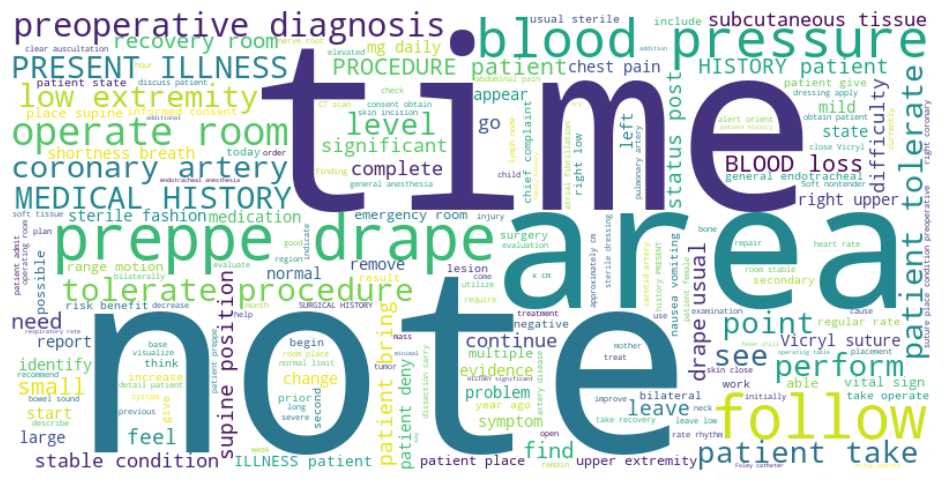

In [11]:
text = " ".join(transcriptions_df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 6. Named Entity Recognition (NER)

Extract diseases, medications, symptoms

Visualize examples

In [12]:
sample_doc = nlp(test_txt)
displacy.render(sample_doc, style="ent", jupyter=True)

## 7. Entity linking with UMLS or SNOMED CT

## 8. Classification – Disease Category


## 9. Conclusion & Insights


## 10. Resources

https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions?resource=download
